In [1]:
# imports (this can take some time!)
using DrWatson
@quickactivate "IEEE14"

using NonLinearSystemNeuralNetworkFMU
using ChainRulesCore
using Flux
using LinearAlgebra
using Statistics
using Plots

include("utils.jl");
include("trainSupervised.jl");
include("trainUnsupervised.jl");
include("trainSemiSupervised.jl");

# Introduction SimpleLoop
- Comparison between Supervised training, Unsupervised training and a combination of them for learning of SimpleLoop data.
- What is SimpleLoop?: https://github.com/AnHeuermann/NonLinearSystemNeuralNetworkFMU.jl/tree/main/examples/SimpleLoop

SimpleLoop describes a growing circle and a moving line and contains a non-linear system solving for the intersection points of the two objects.
$$r^2 = x^2 + y^2$$
$$rs + b = x + y$$
Inputs to the Surrogate are $r$ and $s$ and $b$ is a parameter.
Output of the Surrogate is $y$ and $x$ can be computed from $y$: $x = rs + b - y$

**Supervised training**:
- input output pairs: $\{(x_{1},y_{1}),...,(x_{N},\;y_{N})\}$
- The loss function is MSE: $$L = \sum_i \big( f(x_i ; \theta)-y^*_i \big)^2$$

**Unsupervised Training**:
- only input, no input output pairs: $\{x_{1},...,x_{N}\}$
- The loss function is measuring the residual of output, which should be $0$ at solution: $$L = \sum_i R(f(x_i ; \theta))$$

**Semi-Supervised Training**:
- input output pairs
- The loss function is combining MSE and residual information: $$L = \sum_i \alpha_0 \big( f(x_i ; \theta)-y^*_i \big)^2 + \alpha_1 R(x_i)$$
- hyperparameters for weighting sum to $1$ with: $\alpha_0 + \alpha_1 = 1$
- in all experiments i used: $\alpha_0 = 0.8$ and $\alpha_1 = 0.2$

**Clustering**:
- applied to output data using KMeans
- idea is to identify unique solutions in data and train on these solutions separately

In [66]:
# path of generated data
# insert local path here:
data_path = "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/data/eq_14.csv";
nInputs = 2;
nOutputs = 1;

# insert local paths here:
# path of fmu, profilinginfo and model.c file
interface_fmu_path = "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/simpleLoop.interface.fmu";
profinfo_path = "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/profilingInfo.bson";
modelfile_path = "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/temp-profiling/simpleLoop.c";

# load fmu and other things
comp, fmu, profilinginfo, vr, row_value_reference, eq_num, sys_num = prepare_fmu(interface_fmu_path, profinfo_path, modelfile_path);

(FMU:            simpleLoop
InstanceName:   simpleLoop
Address:        Ptr{Nothing} @0x000000000edea9d0
State:          2
Logging:        0
FMU time:       0.0
FMU states:     nothing, Model name:        simpleLoop
Type:              0, ProfilingInfo[ProfilingInfo(EqInfo(14, 2512, 0.000317798, 1.5827e-5, 0.06756972823105675), ["y"], [11], ["s", "r"], NonLinearSystemNeuralNetworkFMU.MinMaxBoundaryValues{Float64}([0.0, 0.95], [1.4087228258248679, 3.15]))], UInt32[0x00000004], UInt32[0x00000001, 0x00000000], 14, 1)

# 1. Experiment
The output data is **first clustered** and then Supervised, Unsupervised and Semi-Supervised are trained. During training, MSE loss and Residual loss on test data is tracked. After training, trained model predictions on test data are plotted in a scatter plot.

In [67]:
# preparation of 1. experiment
(train_in, train_out, test_in, test_out) = readData(data_path, nInputs)  

# concat in and out data
in_data = hcat(train_in, test_in)
out_data = hcat(train_out, test_out)

x = compute_x_from_y.(in_data[1,:], in_data[2,:], out_data[1,:])
out_data = hcat(x, out_data')'
# cluster out data
cluster_indices, num_clusters = cluster_data(out_data)
# extract cluster
cluster_index = 1
in_data = extract_cluster(in_data, cluster_indices, cluster_index)
out_data = extract_cluster(out_data, cluster_indices, cluster_index)
out_data = out_data[2,:]
out_data = reshape(out_data, 1, length(out_data))
# split one cluster into train and test
train_in, train_out, test_in, test_out = split_train_test(in_data, out_data)
# min max scaling
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true)

461-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float64}}, shuffle=true)
  with first element:
  (2×1 Matrix{Float32}, 1×1 Matrix{Float64},)

In [68]:
# definition of the model for all experiments
# simple MLP with one hidden layer
hidden_width = 100;
model = Flux.Chain(
  Flux.Dense(nInputs, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, nOutputs)
);
# Adam optimizer with learning rate 1e-4
opt = Flux.Adam(1e-4);
# training is done for 100 epochs
epochs = 100;

In [69]:
# 1. experiment
# train all models with same model, same data, same epochs
# only difference: loss function
supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs);
unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs);
semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs, h1=0.8, h2=0.2);

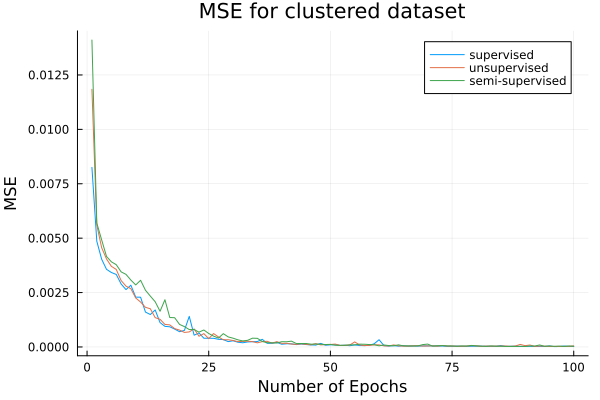

In [70]:
# results of 1. experiment
# plot mse loss on test data
plot_loss_history(supervised_test_loss_hist; label="supervised")
plot_loss_history!(unsupervised_test_loss_hist; label="unsupervised")
plot_loss_history!(semisupervised_test_loss_hist; label="semi-supervised")
title!("MSE for clustered dataset")
xlabel!("Number of Epochs")
ylabel!("MSE")

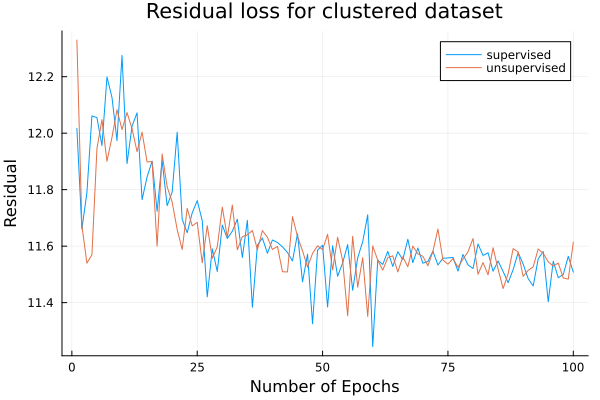

In [71]:
# plot residual loss on test data
plot_loss_history(res_sup; label="supervised")
plot_loss_history!(res_unsup; label="unsupervised")
title!("Residual loss for clustered dataset")
xlabel!("Number of Epochs")
ylabel!("Residual")

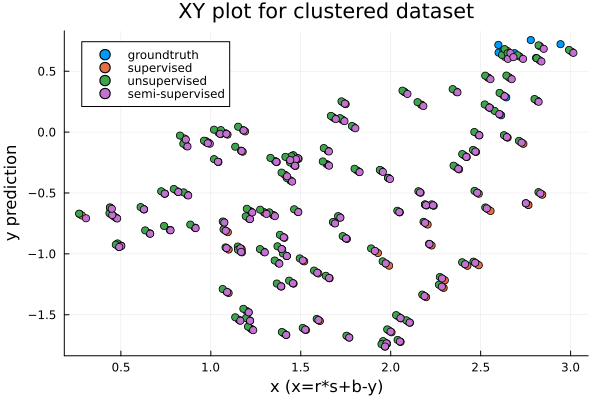

In [72]:
# plot predictions against groundtruth on xy-plane
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
scatter(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth") # reconstruct
plot_xy(supervised_model, test_in, test_out, test_in_t, test_out_t; label="supervised") # reconstruct inside plot xy
plot_xy(unsupervised_model, test_in, test_out, test_in_t, test_out_t; label="unsupervised")
plot_xy(semisupervised_model, test_in, test_out, test_in_t, test_out_t; label="semi-supervised")
title!("XY plot for clustered dataset")
xlabel!("x (x=r*s+b-y)")
ylabel!("y prediction")

# Learnings of 1. Experiment
- Unsupervised training **can converge** to a true solution
- Unsupervised training is also **unguided**, it depends on initialization of the parameters to which solution the Network converges, if at all.
- Unsupervised is only superior to Supervised when clustering is not available: more compute while training, unguided
- Semi-Supervised is an option, when a preferred solution and unique data exists: less data generation, guiding of Unsupervised training

# 2. Experiment
For the second experiment, the only difference to the first is that **no clustering** is done.

In [73]:
# preparation of 2. experiment
# no clustering here
(train_in, train_out, test_in, test_out) = readData(data_path, nInputs);
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out);
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true);

In [74]:
# 2. experiment
supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs);
unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs);
semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs, h1=0.8, h2=0.2);

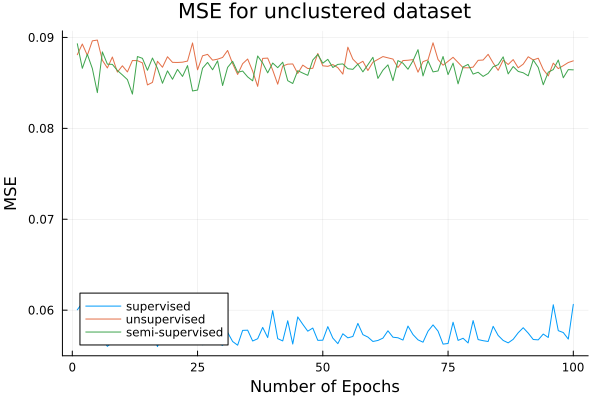

In [75]:
# results of 2. experiment
plot_loss_history(supervised_test_loss_hist; label="supervised")
plot_loss_history!(unsupervised_test_loss_hist; label="unsupervised")
plot_loss_history!(semisupervised_test_loss_hist; label="semi-supervised")
title!("MSE for unclustered dataset")
xlabel!("Number of Epochs")
ylabel!("MSE")

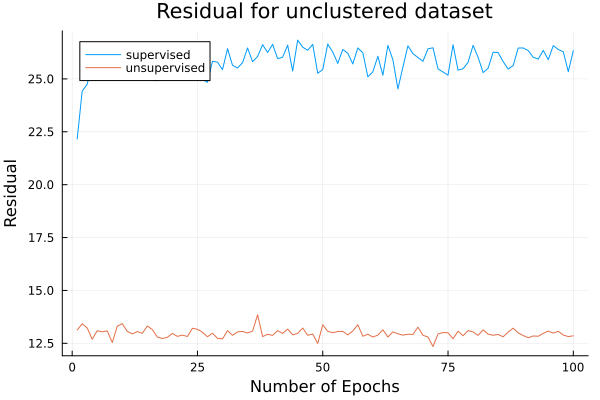

In [76]:
plot_loss_history(res_sup; label="supervised")
plot_loss_history!(res_unsup; label="unsupervised")
title!("Residual for unclustered dataset")
xlabel!("Number of Epochs")
ylabel!("Residual")

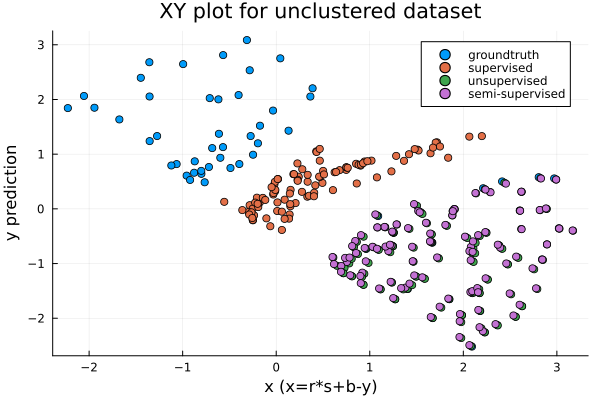

In [77]:
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
scatter(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth")
plot_xy(supervised_model, test_in, test_out, test_in_t, test_out_t; label="supervised") # reconstruct inside plot xy
plot_xy(unsupervised_model, test_in, test_out, test_in_t, test_out_t; label="unsupervised")
plot_xy(semisupervised_model, test_in, test_out, test_in_t, test_out_t; label="semi-supervised")
title!("XY plot for unclustered dataset")
xlabel!("x (x=r*s+b-y)")
ylabel!("y prediction")

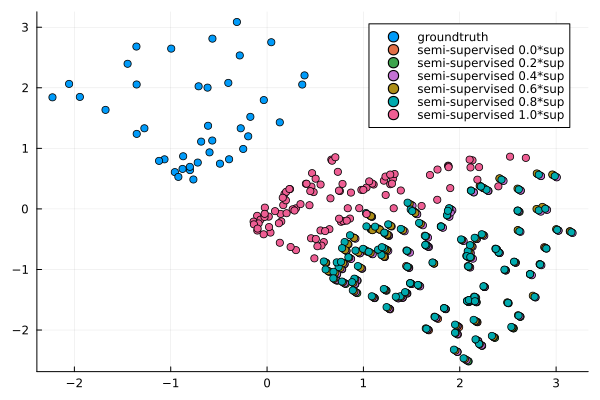

In [78]:
# tune h1 and h2
# trying to figure out how the hyperparameter setting in semi-supervised influences the prediction behaviour
h12 = 0.0:0.2:1.0
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
h12_pl = plot()
plot!(h12_pl, scatter!(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth"))
for h in h12
    h1 = h
    h2 = 1-h
    semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs, h1=h1, h2=h2) 
    plot!(h12_pl, plot_xy(semisupervised_model, test_in, test_out, test_in_t, test_out_t; label="semi-supervised $(h)*sup"))
end
display(h12_pl)

# Learnings of 2. Experiment
- Supervised **cant converge on ambigous data**, averaging multiple modes
- Unsupervised **can converge on ambigous data**
- Semi-Supervised needs tuning of hyperparameters to converge, could they be optimized during training or be part of hyperparam search?
- loss values can be misleading or residual information is wrong

# 3. Experiment
For the third experiment, the **training time of Supervised and Unsupervised** are compared. Both methods are trained for 10, 100 and 1000 epochs and the training time is tracked and compared.

In [79]:
# preparation of 3. experiment
(train_in, train_out, test_in, test_out) = readData(data_path, nInputs);
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out);
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true);

epoch_range = [10,100,1000];
gen_unsupervised_data_time = 0.05; # seconds for 1000 datapoints
gen_supervised_data_time = 25; # seconds for 1000 datapoints

In [80]:
# 3. experiment unsupervised
# train for model once for every entry in epoch_range
full_unsupervised_test_loss_hist = []
full_res_unsupervised_test_loss_hist = []
full_unsupervised_train_time_hist = []
for n_epochs in epoch_range
  unsupervised_model, unsupervised_test_loss_hist, res_unsupervised_test_loss_hist,  unsupervised_time = trainModelUnsupervised(
    deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=n_epochs
    )
    push!(full_unsupervised_test_loss_hist, unsupervised_test_loss_hist[end])
    push!(full_res_unsupervised_test_loss_hist, res_unsupervised_test_loss_hist[end])
    push!(full_unsupervised_train_time_hist, unsupervised_time)
end

In [81]:
# 3. experiment supervised
full_supervised_test_loss_hist = []
full_res_supervised_test_loss_hist = []
full_supervised_train_time_hist = []
for n_epochs in epoch_range
  supervised_model, supervised_test_loss_hist, res_supervised_test_loss_hist, supervised_time = trainModelSupervised(
    deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu;epochs=n_epochs
    )
    push!(full_supervised_test_loss_hist, supervised_test_loss_hist[end])
    push!(full_res_supervised_test_loss_hist, res_supervised_test_loss_hist[end])
    push!(full_supervised_train_time_hist, supervised_time)
end

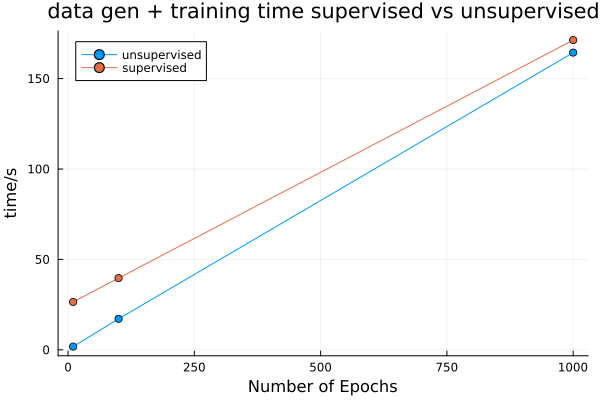

In [82]:
# results of 3. experiment
plot_loss_history(full_unsupervised_train_time_hist .+ gen_unsupervised_data_time, epoch_range; label="unsupervised", marker = :circle)
plot_loss_history!(full_supervised_train_time_hist .+ gen_supervised_data_time, epoch_range; label="supervised", marker = :circle)
title!("data gen + training time supervised vs unsupervised")
xlabel!("Number of Epochs")
ylabel!("time/s")

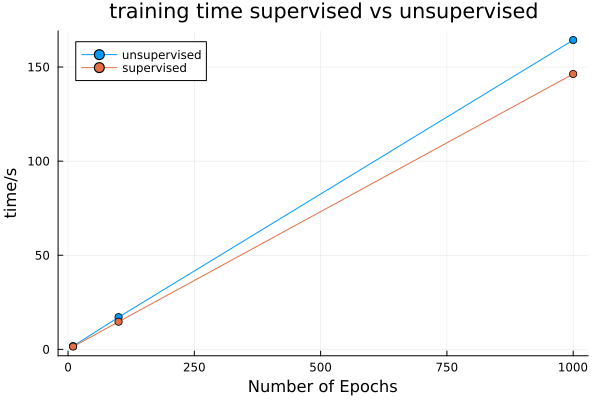

In [83]:
# results of 3. experiment
plot_loss_history(full_unsupervised_train_time_hist, epoch_range; label="unsupervised", marker = :circle)
plot_loss_history!(full_supervised_train_time_hist, epoch_range; label="supervised", marker = :circle)
title!("training time supervised vs unsupervised")
xlabel!("Number of Epochs")
ylabel!("time/s")

# Learnings of 3. Experiment
- training time increases linearly with number of epochs
- unsupervised data generation is **~500 times faster** than supervised data generation
- actual training time of Supervised is lower than Unsupervised

# 4. Experiment
In the fourth experiment, Unsupervised training is compared for **different batchsizes**, namely 1 and 8.

In [84]:
# preparation of 4. experiment
(train_in, train_out, test_in, test_out) = readData(data_path, nInputs);
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out);
dataloader_1 = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true);
dataloader_8 = Flux.DataLoader((train_in, train_out), batchsize=8, shuffle=true);

In [85]:
# 4. experiment
# train once with batchsize 1 and once with batchsize 8
unsupervised_model_1, unsupervised_test_loss_hist_1, res_unsupervised_test_loss_hist_1,  unsupervised_time_1 = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader_1, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs);
unsupervised_model_8, unsupervised_test_loss_hist_8, res_unsupervised_test_loss_hist_8,  unsupervised_time_8 = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader_8, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs);

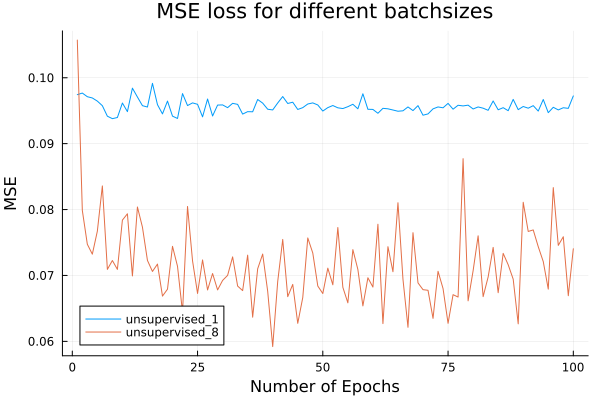

In [86]:
# results of 4. experiment
plot_loss_history(unsupervised_test_loss_hist_1; label="unsupervised_1")
plot_loss_history!(unsupervised_test_loss_hist_8; label="unsupervised_8")
title!("MSE loss for different batchsizes")
xlabel!("Number of Epochs")
ylabel!("MSE")

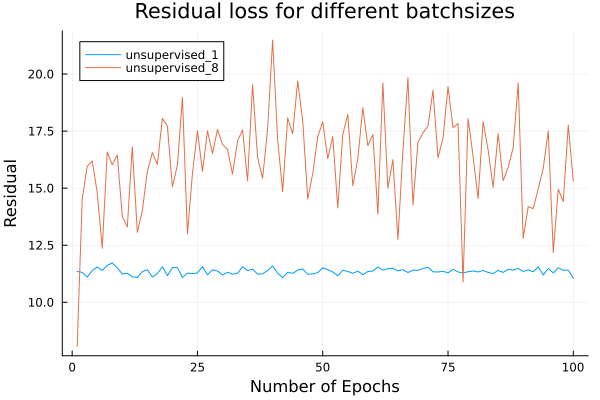

In [87]:
plot_loss_history(res_unsupervised_test_loss_hist_1; label="unsupervised_1")
plot_loss_history!(res_unsupervised_test_loss_hist_8; label="unsupervised_8")
title!("Residual loss for different batchsizes")
xlabel!("Number of Epochs")
ylabel!("Residual")

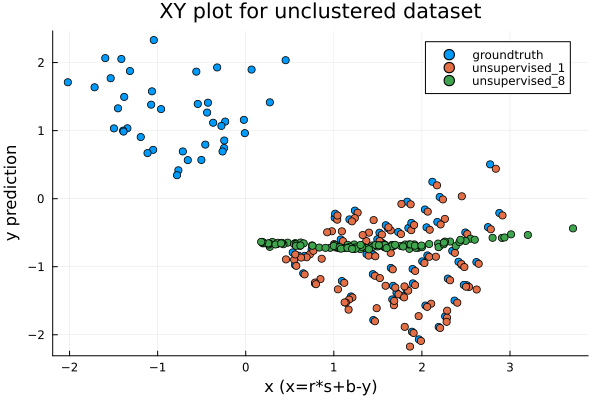

In [88]:
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
scatter(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth")
plot_xy(unsupervised_model_1, test_in, test_out, test_in_t, test_out_t; label="unsupervised_1")
plot_xy(unsupervised_model_8, test_in, test_out, test_in_t, test_out_t; label="unsupervised_8")
title!("XY plot for unclustered dataset")
xlabel!("x (x=r*s+b-y)")
ylabel!("y prediction")

# Learnings of 4. Experiment
- Unsupervised is probably useless cause **bigger batchsize leads to problems**.
- possible reasons: wrong backprop through reconstruct, if no reconstruct finite diff works out but prediction is way off
- maybe batchsize factor is wrong
- transpose(jac) * res is correct
- "linear" prediction

# Introduction IEEE14
What is IEEE14?: https://github.com/AnHeuermann/NonLinearSystemNeuralNetworkFMU.jl/tree/main/examples/IEEE14

The Modelica model Examples.IEEE14.IEEE_14_Buses from the OpenIPSL library has one large non-linear equation system that is very hard to replace with a working surrogate.
Unsupervised training is investigated in that **higher dimensional scenario** with 15 inputs and 110 outputs. The loss on test data is tracked and the model predictions are plotted in 3D using PCA. 

In addition to Supervised, Unsupervised and Semi-Supervised, a Two-Step training procedure is tested which trains Unsupervised for the first half of epochs and Supervised with freezed layers for second half of epochs.

In [2]:
# imports
using MultivariateStats
include("trainTwoStep.jl");

In [3]:
# IEEE14 residual
# insert local path here:
data_path = "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/data/eq_1403.csv";
nInputs = 16;
nOutputs = 110;

# insert local paths here:
interface_fmu_path = "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/IEEE_14_Buses.interface.fmu";
profinfo_path = "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/profilingInfo.bson";
modelfile_path = "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/temp-profiling/IEEE_14_Buses.c";

comp, fmu, profilinginfo, vr, row_value_reference, eq_num, sys_num = prepare_fmu(interface_fmu_path, profinfo_path, modelfile_path);

# prepare train and test data
(train_in, train_out, test_in, test_out) = readData(data_path, nInputs);

┌ Warning: No variable named 'time' found.
└ @ FMIImport /home/fbrandt3/.julia/packages/FMIImport/qrNjL/src/FMI2/convert.jl:153
┌ Warning: Value reference for variable 'time' not found, skipping.
└ @ FMIImport /home/fbrandt3/.julia/packages/FMIImport/qrNjL/src/FMI2/convert.jl:76


In [4]:
CLUSTER = false;
if CLUSTER
  # concat in and out data
  in_data = hcat(train_in, test_in);
  out_data = hcat(train_out, test_out);

  # cluster out data
  cluster_indices, num_clusters = cluster_data(out_data);
  # extract cluster
  cluster_index = 1; #rand(1:num_clusters)
  in_data = extract_cluster(in_data, cluster_indices, cluster_index);
  out_data = extract_cluster(out_data, cluster_indices, cluster_index);
else
  # take time out, probably earlier
  in_data = hcat(train_in, test_in)
  out_data = hcat(train_out, test_out)
end

110×1500 Matrix{Float32}:
 -0.0498908  -0.0684682  -0.0535168  …  -0.0220593  -0.0241518  -0.0205506
  0.0341627   0.0354746   0.0348302      0.0254036   0.0249079   0.0258405
  0.156014    0.158687    0.153326       0.235265    0.219576    0.258632
 -0.115809   -0.117385   -0.113433      -0.206699   -0.191886   -0.229346
  0.205678    0.160772    0.20459        0.78324     0.749711    0.804245
  0.0526958   0.0661463   0.0875314  …   1.67544     1.6403      1.7297
  0.828095    0.883216    0.856413       0.758277    0.741938    0.715648
  0.0968446   0.0997403   0.098581       0.0639309   0.0625793   0.0646571
  0.199047    0.150397    0.189628       0.394439    0.368776    0.402555
 -0.0457433  -0.0473458  -0.0452227     -0.0264273  -0.0258313  -0.0278325
  ⋮                                  ⋱                          
  0.925773    0.956539    0.934769       0.654646    0.6409      0.664426
 -0.38535    -0.395863   -0.374779      -0.250747   -0.241708   -0.257082
 -0.404129   -0.413

In [5]:
# Warning: No variable named 'time' found.
in_data = in_data[2:end,:];  # take time variable out of in data

In [6]:
# split one cluster into train and test
train_in, train_out, test_in, test_out = split_train_test(in_data, out_data);
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out);
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true);

In [7]:
hidden_width = 100;
model = Flux.Chain(
  Flux.Dense(nInputs-1, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, nOutputs)
);

opt = Flux.Adam(1e-4);
epochs = 1000;

In [8]:
unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs);
supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs);
semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs, h1=0.8, h2=0.2);
twost_model, twost_test_loss_hist, twost_time = trainTwoStep(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs);

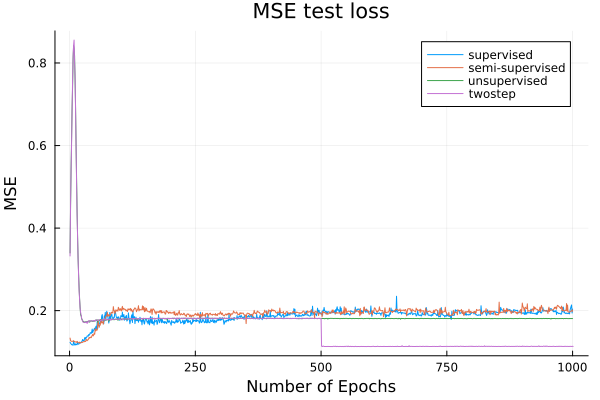

In [9]:
plot_loss_history(supervised_test_loss_hist; label="supervised")
plot_loss_history!(semisupervised_test_loss_hist; label="semi-supervised")
plot_loss_history!(unsupervised_test_loss_hist; label="unsupervised")
plot_loss_history!(twost_test_loss_hist; label="twostep")
title!("MSE test loss")
xlabel!("Number of Epochs")
ylabel!("MSE")

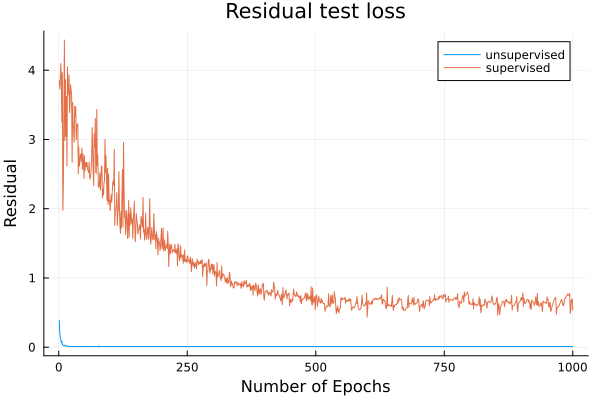

In [10]:
plot_loss_history(res_unsup; label="unsupervised")
plot_loss_history!(res_sup; label="supervised")
title!("Residual test loss")
xlabel!("Number of Epochs")
ylabel!("Residual")

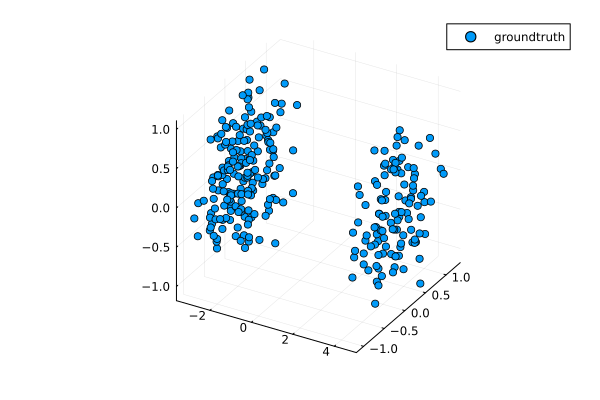

In [11]:
M1 = fit(PCA, test_out; maxoutdim=3)
O1 = predict(M1, test_out)
scatter(O1[1,:],O1[2,:],O1[3,:], label="groundtruth")

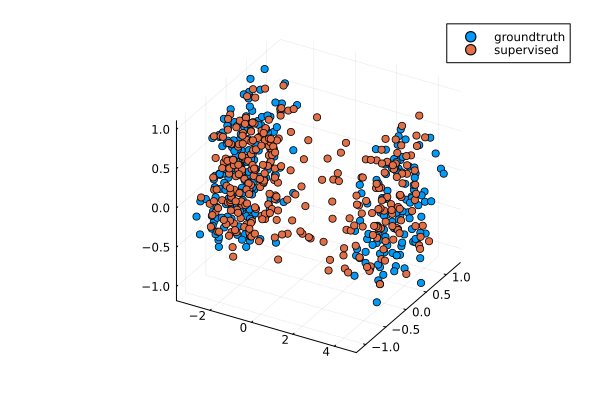

In [12]:
pred3 = supervised_model(test_in)
O3 = predict(M1, pred3)
scatter!(O3[1,:],O3[2,:],O3[3,:], label="supervised")

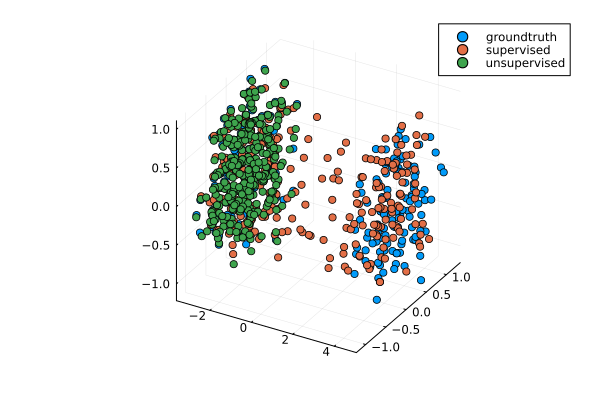

In [13]:
pred2 = unsupervised_model(test_in)
O2 = predict(M1, pred2)
scatter!(O2[1,:],O2[2,:],O2[3,:], label="unsupervised")

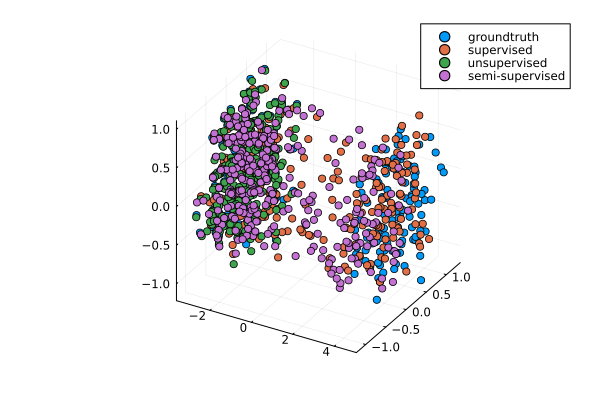

In [14]:
pred4 = semisupervised_model(test_in)
O4 = predict(M1, pred4)
scatter!(O4[1,:],O4[2,:],O4[3,:], label="semi-supervised")

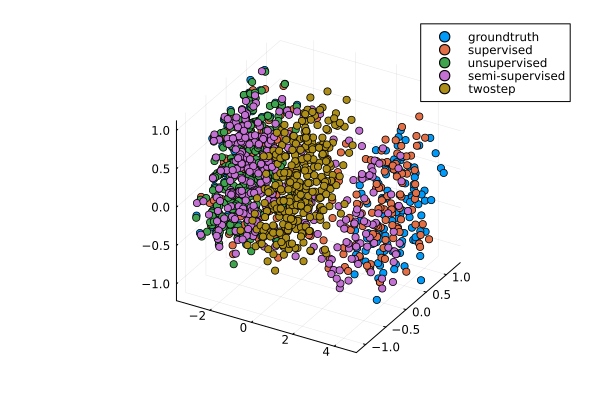

In [15]:
pred5 = twost_model(test_in)
O5 = predict(M1, pred5)
scatter!(O5[1,:],O5[2,:],O5[3,:], label="twostep")

# Learnings of IEEE14
- Unsupervised can handle higher dimensions.
- here as well: a bigger batchsize leads to problems

# Results/Conclusion of whole Notebook
- fast data generation is good
- Unsupervised can work in small and high dimensions
- gradient computation for batchsize > 1 is wrong

In [38]:
# average multiple runs
num_runs = 5
mean_loss_hist_sup = []
for i in 1:num_runs
    supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)
    if i == 1
        mean_loss_hist_sup = supervised_test_loss_hist
    else
        #mean_loss_hist *= i-1 maybe this
        mean_loss_hist_sup += supervised_test_loss_hist
        mean_loss_hist_sup /= i
    end
end

mean_loss_hist_unsup = []
for i in 1:num_runs
    unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs)
    if i == 1
        mean_loss_hist_unsup = unsupervised_test_loss_hist
    else
        #mean_loss_hist *= i-1 maybe this
        mean_loss_hist_unsup += unsupervised_test_loss_hist
        mean_loss_hist_unsup /= i
    end
end

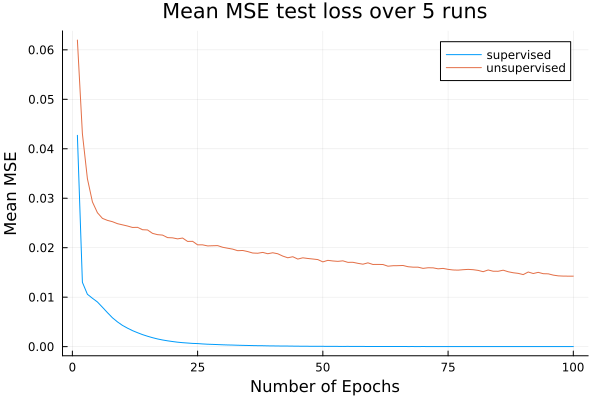

In [39]:
plot_loss_history(mean_loss_hist_sup; label="supervised")
plot_loss_history!(mean_loss_hist_unsup; label="unsupervised")
title!("Mean MSE test loss over $(num_runs) runs")
xlabel!("Number of Epochs")
ylabel!("Mean MSE")